In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# VAE for genetic circuits

In this notebook, we will follow RaptGen more closely ([Generative aptamer discovery using RaptGen](https://www.nature.com/articles/s43588-022-00249-6#Fig1)) and implement a the VAE encoder. See the [VAE class](https://github.com/hmdlab/raptgen/blob/c4986ca9fa439b9389916c05829da4ff9c30d6f3/raptgen/models.py#L807) in the RaptGen repo.


## Imports

In [ ]:
# %env XLA_PYTHON_CLIENT_ALLOCATOR=platform

from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from functools import partial

from sklearn.metrics import r2_score  
import os
import sys
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import optax  # https://github.com/deepmind/optax
from jaxtyping import Array, Float, Int  # https://github.com/google/jaxtyping

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
                
import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


jax.devices()

[gpu(id=0)]

In [16]:
from src.models.vae import VAE
from src.models.mlp import MLP
from src.models.shared import arrayise
from src.losses.losses import loss_fn, compute_accuracy_regression
from src.utils.data_preprocessing import drop_duplicates_keep_first_n
from src.utils.optimiser import make_optimiser
from src.utils.train import train

## Load Data

In [17]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

# Hyperparameters

In [18]:
# Architecture
HIDDEN_SIZE = 32
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3


BATCH_SIZE = 128
N_BATCHES = 1200
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
TRAIN_SPLIT = 0.8
SCALE_X = False
LEARNING_RATE = 5e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 100
PRINT_EVERY = EPOCHS // 10
SEED = 1
input_concat_axis = 0

USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = False

loss_fn = partial(
    loss_fn, loss_type='mse', use_l2_reg=USE_L2_REG)
compute_accuracy = compute_accuracy_regression

subtask = '_test'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + subtask
save_path = os.path.join('weight_saves', '09_vae', save_path)

rng = jax.random.PRNGKey(SEED)

# Initialise 

## Init data

In [31]:
filt = data['sample_name'] == data['sample_name'].unique()[0]

# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True), n=100)

TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])
N_BATCHES = TOTAL_DS // BATCH_SIZE
TOTAL_DS = N_BATCHES * BATCH_SIZE

x_cols = [get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]

x = [df[i].iloc[:TOTAL_DS].values[:, :, None] for i in x_cols]
x = np.concatenate(x, axis=input_concat_axis+1).squeeze()

y = x

x, y = shuffle(x, y, random_state=SEED)

N_HEAD = x.shape[-1]


if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

In [32]:
x.shape

(153600, 6)

In [33]:
if SCALE_X:
    xscaler, yscaler = MinMaxScaler(), MinMaxScaler()
    x = xscaler.fit_transform(x)
    y = xscaler.fit_transform(y)

## Init model

In [22]:
enc_layers = [64] * NUM_ENC_LAYERS
dec_layers = [64] * NUM_DEC_LAYERS

def VAE_fn(x: np.ndarray, enc_layers: list, dec_layers: list, call_kwargs: dict = {}):
    encoder = MLP(layer_sizes=enc_layers, n_head=dec_layers[0], use_categorical=False, name='encoder')
    decoder = MLP(layer_sizes=dec_layers, n_head=x.shape[-1], use_categorical=False, name='decoder')

    model = VAE(encoder=encoder, decoder=decoder, embed_size=HIDDEN_SIZE)
    return model(x, **call_kwargs)

model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers, call_kwargs={'key': rng})
model = hk.transform(model_fn)
params = model.init(rng, x[:2])


/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


## Init optimiser

In [23]:
optimiser = make_optimiser(LEARNING_RATE_SCHED, LEARNING_RATE,
                           EPOCHS, L2_REG_ALPHA, USE_WARMUP, WARMUP_EPOCHS, N_BATCHES)
optimiser_state = optimiser.init(x)

# Train

In [24]:
# [i_batch, xy, Batches, *content]
        
x = x.reshape(N_BATCHES, 1, BATCH_SIZE, x.shape[-1])
y = y.reshape(N_BATCHES, 1, BATCH_SIZE, y.shape[-1])

x_train, y_train = x[:int(TRAIN_SPLIT * N_BATCHES)], y[:int(TRAIN_SPLIT * N_BATCHES)]
x_val, y_val = x[int(TRAIN_SPLIT * N_BATCHES):], y[int(TRAIN_SPLIT * N_BATCHES):]
xy_train = np.concatenate([x_train, y_train], axis=1)

In [25]:
params, saves = train(params, rng, model, xy_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      loss_fn=loss_fn, compute_accuracy=loss_fn,
                      save_every=PRINT_EVERY, include_params_in_saves=False) 

Epoch 0 / 100 -		 Train loss: 14.653785705566406	Val loss: 14.427469253540039	Val accuracy: 14.427469253540039
Epoch 10 / 100 -		 Train loss: 13.64722728729248	Val loss: 13.55930233001709	Val accuracy: 13.55930233001709
Epoch 20 / 100 -		 Train loss: 13.466217994689941	Val loss: 13.393377304077148	Val accuracy: 13.393377304077148
Epoch 30 / 100 -		 Train loss: 13.419185638427734	Val loss: 13.350049018859863	Val accuracy: 13.350049018859863
Epoch 40 / 100 -		 Train loss: 13.39565658569336	Val loss: 13.32848834991455	Val accuracy: 13.32848834991455
Epoch 50 / 100 -		 Train loss: 13.375405311584473	Val loss: 13.310099601745605	Val accuracy: 13.310099601745605
Epoch 60 / 100 -		 Train loss: 13.355058670043945	Val loss: 13.29146671295166	Val accuracy: 13.29146671295166
Epoch 70 / 100 -		 Train loss: 13.333891868591309	Val loss: 13.271986961364746	Val accuracy: 13.271986961364746
Epoch 80 / 100 -		 Train loss: 13.311235427856445	Val loss: 13.251020431518555	Val accuracy: 13.251020431518555
E

# Visualise

Text(0.5, 0, 'step')

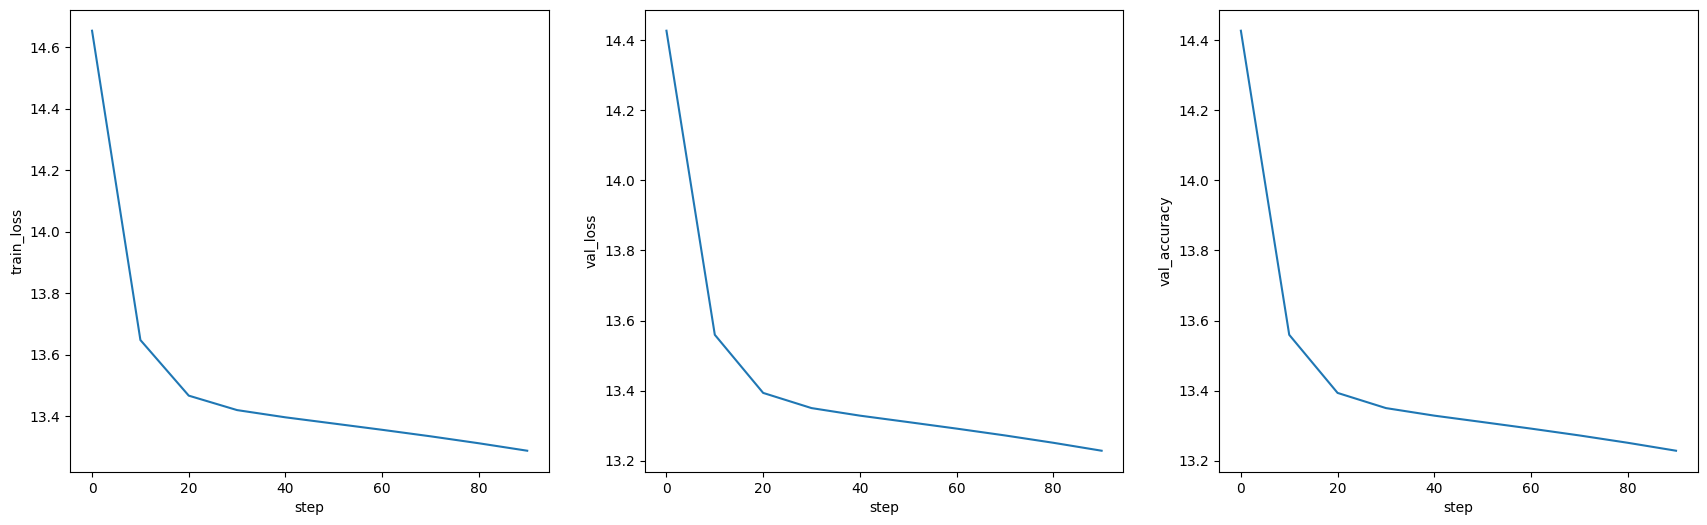

In [26]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

In [ ]:
write_json(saves, out_path=save_path)


## Examine trained model


In [ ]:
# fn_saves = os.path.join('weight_saves', '08_encoder_decoder', '2023_12_07__12_27_41_saves_test')
fn_saves = save_path
if not os.path.isfile(fn_saves):
    fn_saves = save_path
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)

pred_y = model.apply(p, rng, x[0], call_kwargs={'inference': True, 'logging': False})
pred_y.shape

NameError: name 'r2_score' is not defined

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


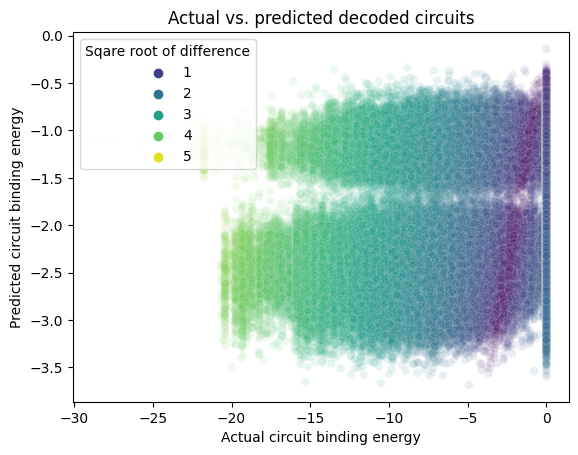

In [28]:
g = sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')
# plt.legend(title='')

print('The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

## Visualise network

In [35]:
import graphviz


model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers, call_kwargs={'key': rng})
model = hk.transform(model_fn)
params2 = model.init(rng, x[:2])
dot = hk.experimental.to_dot(model_fn)(x)

graphviz.Source(dot)

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


ValueError: All `hk.Module`s must be initialized inside an `hk.transform`.

In [37]:
# print(hk.experimental.tabulate(model.apply)(x_val))
